# Feature selection with Boruta-SHAP to increase your score

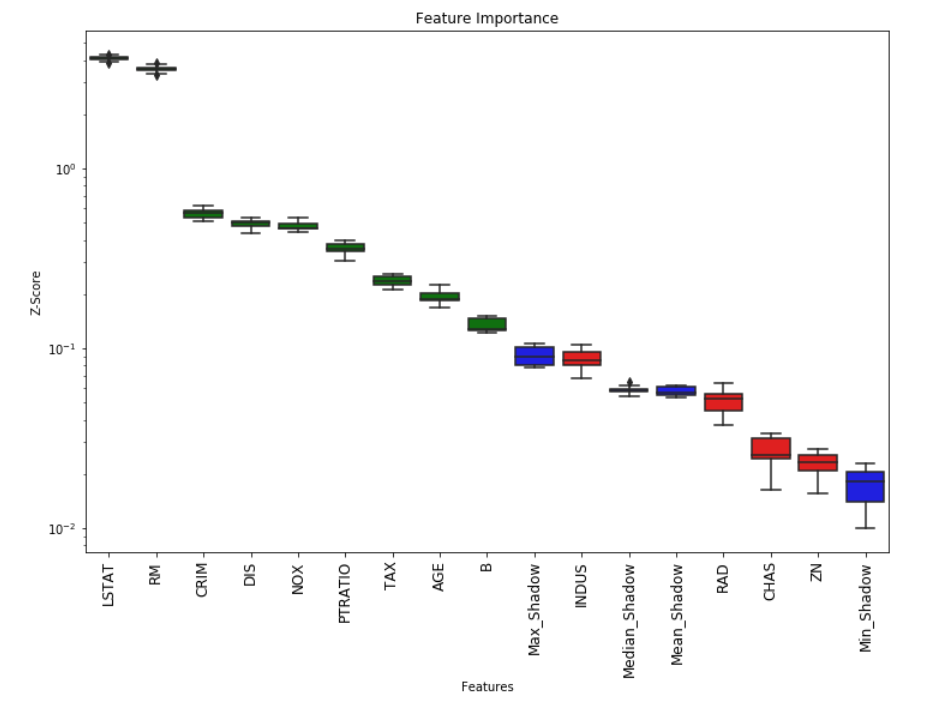

#### As the competition is approaching the end, it is becoming clear that it has become a battle of ensembles. 

How can you win in such a battle?

 1. by training new useful models that others don't have in their ensemble
 2. by making your models run better

Gradient Boosting incorporates feature selection, since the trees spit only on significant features (or at least they should). In reality, this is not always true as sometimes noisy, irrelevant splits may appear in the tree. Moreover, working with not useful features will cause your training to go slower.

Generally, widely recognized benefits of featue selection are:

* simplification of models to make them easier to interpret
* shorter training times,
* to avoid the curse of dimensionality,
* more generalization by reducing overfitting (reduction of variance)

Boruta-SHAP is a package combining Boruta (https://github.com/scikit-learn-contrib/boruta_py), a feature selection method based on repeated tests of the importance of a feature in a model, with the interpretability method SHAP (https://christophm.github.io/interpretable-ml-book/shap.html).

Boruta-SHAP, developed by Eoghan Keany (https://github.com/Ekeany/Boruta-Shap), is extremely simple to use: get your best model, let it run some time on Boruta-SHAP and evaluate the results!

p.s
p.s. You can read more about Boruta-SHAP on this Medium article by the author: https://medium.com/analytics-vidhya/is-this-the-best-feature-selection-algorithm-borutashap-8bc238aa1677

#### Let's start by uploading packages and data

In [1]:
!pip install BorutaShap

In [2]:
!pip install scikit-learn -U

     |████████████████████████████████| 22.3 MB 1.7 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.23.2
    Uninstalling scikit-learn-0.23.2:
      Successfully uninstalled scikit-learn-0.23.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyldavis 3.3.1 requires numpy>=1.20.0, but you have numpy 1.19.5 which is incompatible.
pdpbox 0.2.1 requires matplotlib==3.1.1, but you have matplotlib 3.4.2 which is incompatible.
hypertools 0.7.0 requires scikit-learn!=0.22,<0.24,>=0.19.1, but you have scikit-learn 0.24.2 which is incompatible.


In [3]:
# Importing core libraries
import numpy as np
import pandas as pd
from time import time
import pprint
import joblib
from functools import partial

# Suppressing warnings because of skopt verbosity
import warnings
warnings.filterwarnings("ignore")

# Classifier/Regressor
from xgboost import XGBRegressor

# Feature selection
from BorutaShap import BorutaShap

# Data processing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.mixture import GaussianMixture

# Validation
from sklearn.model_selection import StratifiedKFold

In [4]:
# Loading data 
X_train = pd.read_csv("../input/30-days-of-ml/train.csv")
X_test = pd.read_csv("../input/30-days-of-ml/test.csv")

In [5]:
# Preparing data as a tabular matrix
y_train = X_train.target
X_train = X_train.set_index('id').drop('target', axis='columns')
X_test = X_test.set_index('id')

In [6]:
categoricals = [item for item in X_train.columns if 'cat' in item]
numerics = [item for item in X_train.columns if 'cont' in item]

#### Since there is some discussion if the categorical features are ordinal or not, we process them both by one-hot encoding and ordinal encoding. If a categorical feature is ordinal, the ordinal encoding should prevail and be detected as significant by Boruta-SHAP.

In [7]:
# Dealing with categorical data using get_dummies
dummies = pd.get_dummies(X_train.append(X_test)[categoricals])
X_train[dummies.columns] = dummies.iloc[:len(X_train), :]
X_test[dummies.columns] = dummies.iloc[len(X_train): , :]
del(dummies)

In [8]:
# Dealing with categorical data using OrdinalEncoder (only when there are 3 or more levels)
ordinal_encoder = OrdinalEncoder()
X_train[categoricals[3:]] = ordinal_encoder.fit_transform(X_train[categoricals[3:]])
X_test[categoricals[3:]] = ordinal_encoder.transform(X_test[categoricals[3:]])
X_train = X_train.drop(categoricals[:3], axis="columns")
X_test = X_test.drop(categoricals[:3], axis="columns")

In [9]:
# Stratifying the target for cross-validation
km = KMeans(n_clusters=32, random_state=0)
pca = PCA(n_components=16, random_state=0)

pca.fit(X_train)
km.fit(pca.transform(X_train))
y_stratified = km.labels_

#### Since continuous variables seems a mixture of distributions, we also test how would rank their transformation by factor analysis, pca and gaussian mixtures

In [10]:
fa = FactorAnalysis(n_components=len(numerics), rotation='varimax', random_state=0)
fa.fit(X_train[numerics])

extra_feats = [f'fa_{i}'for i in range(len(numerics))][:2]

X_train[extra_feats] = fa.transform(X_train[numerics])[:,:2]
X_test[extra_feats] = fa.transform(X_test[numerics])[:,:2]

In [11]:
pca = PCA(n_components=len(numerics), random_state=0)
pca.fit(X_train[numerics])

pca_feats = [f'pca_{i}'for i in range(len(numerics))]

X_train[pca_feats] = pca.transform(X_train[numerics])
X_test[pca_feats] = pca.transform(X_test[numerics])

extra_feats += pca_feats

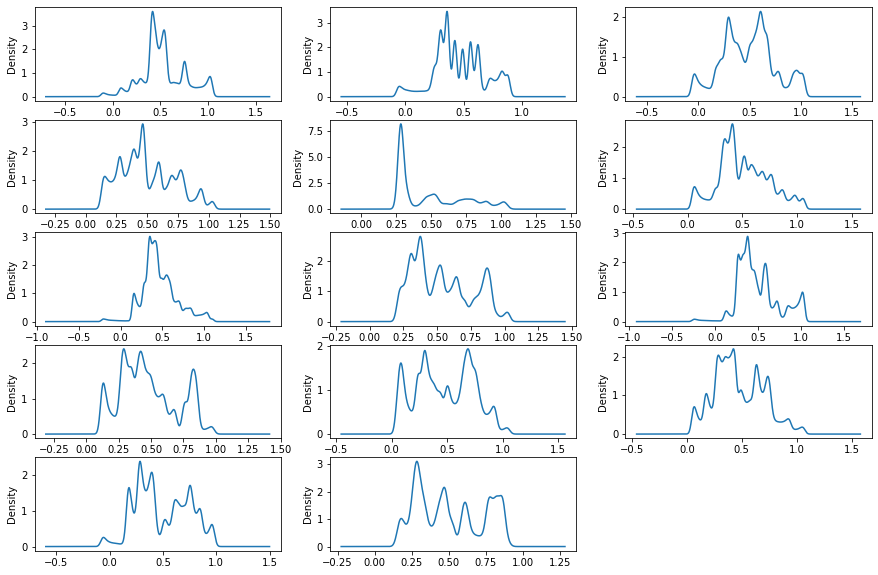

In [12]:
from matplotlib import pyplot as plt
numerics = [f"cont{i}" for i in range(14)]
plt.figure(figsize=(15, 10))
for k, num in enumerate(numerics):
    plt.subplot(5, 3, k+1)
    X_train[num].plot.density()
plt.show()

In [13]:
dists = [30, 32, 32, 29, 28, 31, 22, 32, 13, 27, 32, 30, 27, 25] 
dists += [15, 9, 12, 11, 7, 6, 6, 2, 10, 2, 4, 4, 4, 7, 8]

for feature, dist in zip(numerics + extra_feats, dists):
    x = X_train[[feature]].append(X_test[[feature]])[feature].values.reshape(-1, 1)
    gmm = GaussianMixture(n_components=dist,
                           max_iter=300,
                           random_state=0).fit(x)    
    clus = pd.get_dummies(gmm.predict(x)).values * x
    clus_train = clus[:len(X_train), :]
    clus_test = clus[len(X_train):, :]
    
    clus_feats = [f'{feature}_gmm_dev_{i}'for i in range(clus_train.shape[1])]
    X_train[clus_feats] = clus_train
    X_test[clus_feats] = clus_test

#### Now we pick our best model and let Boruta-SHAP run a few experiments (usually 50 are enough) before getting the results.

#### We cross-validate our experiments in order to ascertain that we are indeed picking the right variables

#### as the results are prepared and we can plot them to visualize the Z-scores intervals of our features. That will signal us the confidence of the choice made by the algorithm in selecting or rejecting features.

#### Please notice that the last two features are noisy features used by Boruta-SHAP to fgure out the important features. Clearly they are non-significant.

#### Cross-validation takes time. Meanwhile we can grab a cup of coffee and relax as Boruta-SHAP is doing all the heavy-lift job.

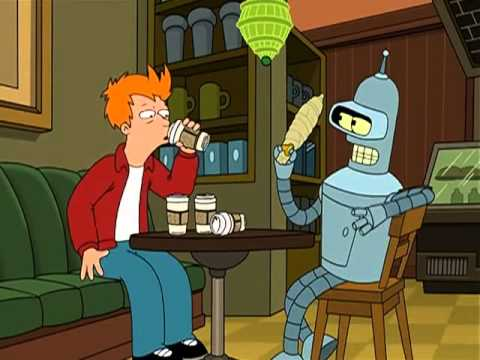

FOLD 1/3


  0%|          | 0/50 [00:00<?, ?it/s]

42 attributes confirmed important: ['cont0', 'cont9_gmm_dev_15', 'cont4_gmm_dev_17', 'cont2', 'cont10', 'cont5', 'cont6', 'pca_8_gmm_dev_0', 'cat8_E', 'cont13', 'cont4', 'cont12_gmm_dev_16', 'pca_2', 'cat1_B', 'cont10_gmm_dev_20', 'pca_3', 'cont12_gmm_dev_8', 'cont10_gmm_dev_24', 'cont8', 'cont12_gmm_dev_20', 'cat1_A', 'cont1', 'cont10_gmm_dev_17', 'pca_7', 'cont12', 'cont9', 'cont7', 'cont11', 'cont3', 'pca_12', 'cont11_gmm_dev_3', 'cont10_gmm_dev_8', 'cont7_gmm_dev_14', 'cont10_gmm_dev_3', 'cont12_gmm_dev_3', 'cont12_gmm_dev_12', 'cont9_gmm_dev_9', 'cont10_gmm_dev_1', 'cont9_gmm_dev_1', 'pca_8', 'cat8_C', 'cont10_gmm_dev_4']
538 attributes confirmed unimportant: ['cont1_gmm_dev_6', 'pca_2_gmm_dev_1', 'cont10_gmm_dev_27', 'cont4_gmm_dev_13', 'pca_11_gmm_dev_3', 'cont10_gmm_dev_23', 'cont12_gmm_dev_11', 'pca_9_gmm_dev_2', 'pca_0_gmm_dev_2', 'cont4_gmm_dev_21', 'cont11_gmm_dev_10', 'cont5_gmm_dev_25', 'fa_0_gmm_dev_0', 'cont4_gmm_dev_5', 'pca_6_gmm_dev_4', 'cat4_B', 'cont7_gmm_dev_9', '

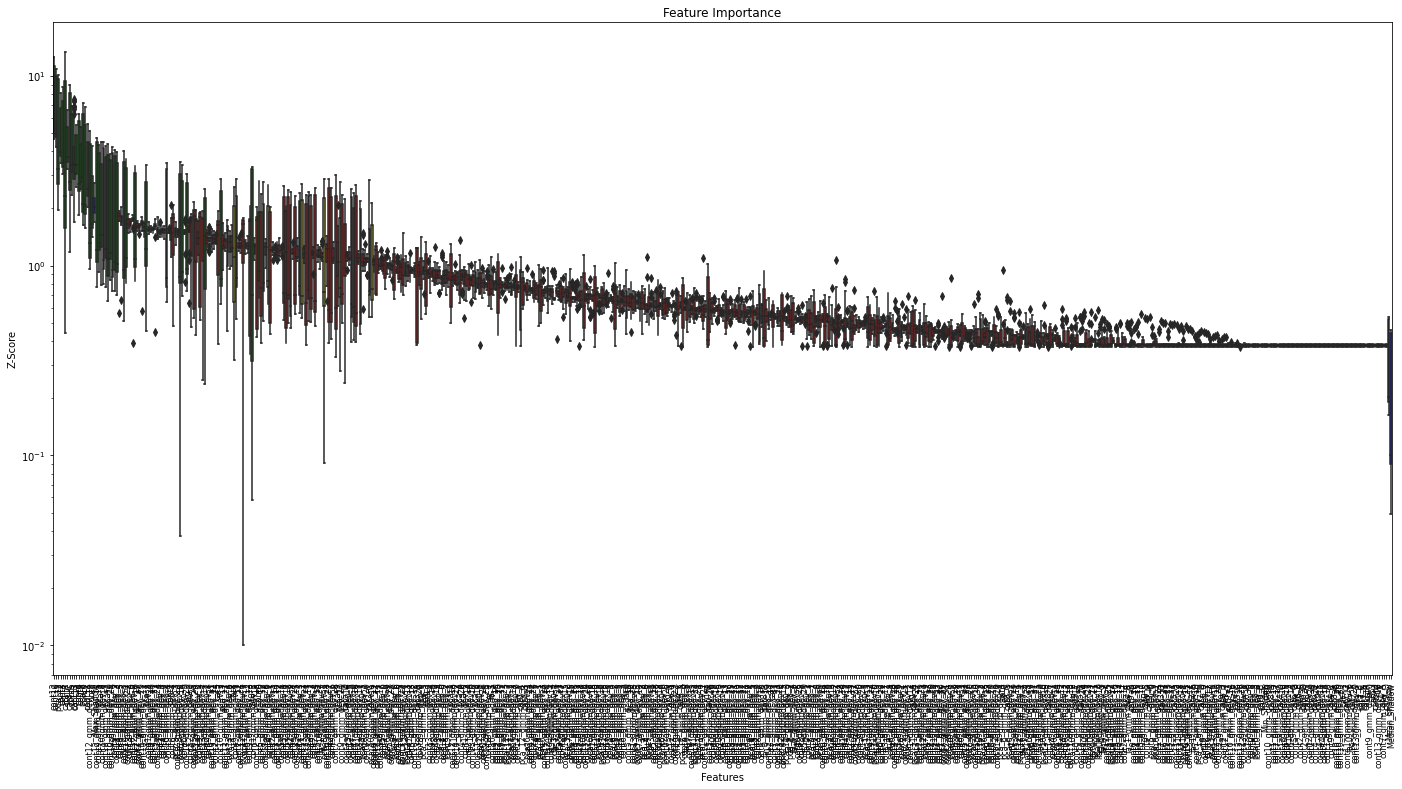

Selected features at fold 1 are: ['cat1_A', 'cat1_B', 'cat8_C', 'cat8_E', 'cont0', 'cont1', 'cont10', 'cont10_gmm_dev_1', 'cont10_gmm_dev_17', 'cont10_gmm_dev_20', 'cont10_gmm_dev_24', 'cont10_gmm_dev_3', 'cont10_gmm_dev_4', 'cont10_gmm_dev_8', 'cont11', 'cont11_gmm_dev_3', 'cont12', 'cont12_gmm_dev_12', 'cont12_gmm_dev_16', 'cont12_gmm_dev_20', 'cont12_gmm_dev_3', 'cont12_gmm_dev_8', 'cont13', 'cont2', 'cont3', 'cont4', 'cont4_gmm_dev_17', 'cont5', 'cont6', 'cont7', 'cont7_gmm_dev_14', 'cont8', 'cont9', 'cont9_gmm_dev_1', 'cont9_gmm_dev_15', 'cont9_gmm_dev_9', 'pca_12', 'pca_2', 'pca_3', 'pca_7', 'pca_8', 'pca_8_gmm_dev_0']
FOLD 2/3


  0%|          | 0/50 [00:00<?, ?it/s]

55 attributes confirmed important: ['cont0', 'cont9_gmm_dev_15', 'cont4_gmm_dev_17', 'cont7_gmm_dev_18', 'cont2', 'cont10', 'cont5', 'cont2_gmm_dev_7', 'cont2_gmm_dev_9', 'cont2_gmm_dev_21', 'cont6', 'pca_11', 'cont9_gmm_dev_20', 'cont13', 'cont4', 'cont4_gmm_dev_1', 'pca_8_gmm_dev_3', 'cont12_gmm_dev_16', 'pca_2', 'cat1_B', 'cont10_gmm_dev_20', 'pca_3', 'cont12_gmm_dev_8', 'cont10_gmm_dev_24', 'cont8', 'cat1_A', 'cont1', 'cont5_gmm_dev_10', 'cont3_gmm_dev_1', 'cont10_gmm_dev_17', 'pca_7', 'cont12', 'cont9', 'cont7', 'cont11', 'cont3', 'cat3_C', 'pca_12', 'cont11_gmm_dev_3', 'cont3_gmm_dev_2', 'cont7_gmm_dev_0', 'cont10_gmm_dev_8', 'cont7_gmm_dev_14', 'cont10_gmm_dev_3', 'cont7_gmm_dev_28', 'cont12_gmm_dev_3', 'fa_0', 'cont12_gmm_dev_12', 'cont9_gmm_dev_9', 'cont10_gmm_dev_1', 'cont9_gmm_dev_1', 'cat5_D', 'pca_8', 'cat8_C', 'cont10_gmm_dev_4']
530 attributes confirmed unimportant: ['cont1_gmm_dev_6', 'pca_2_gmm_dev_1', 'cont10_gmm_dev_27', 'cont4_gmm_dev_13', 'pca_11_gmm_dev_3', 'cont1

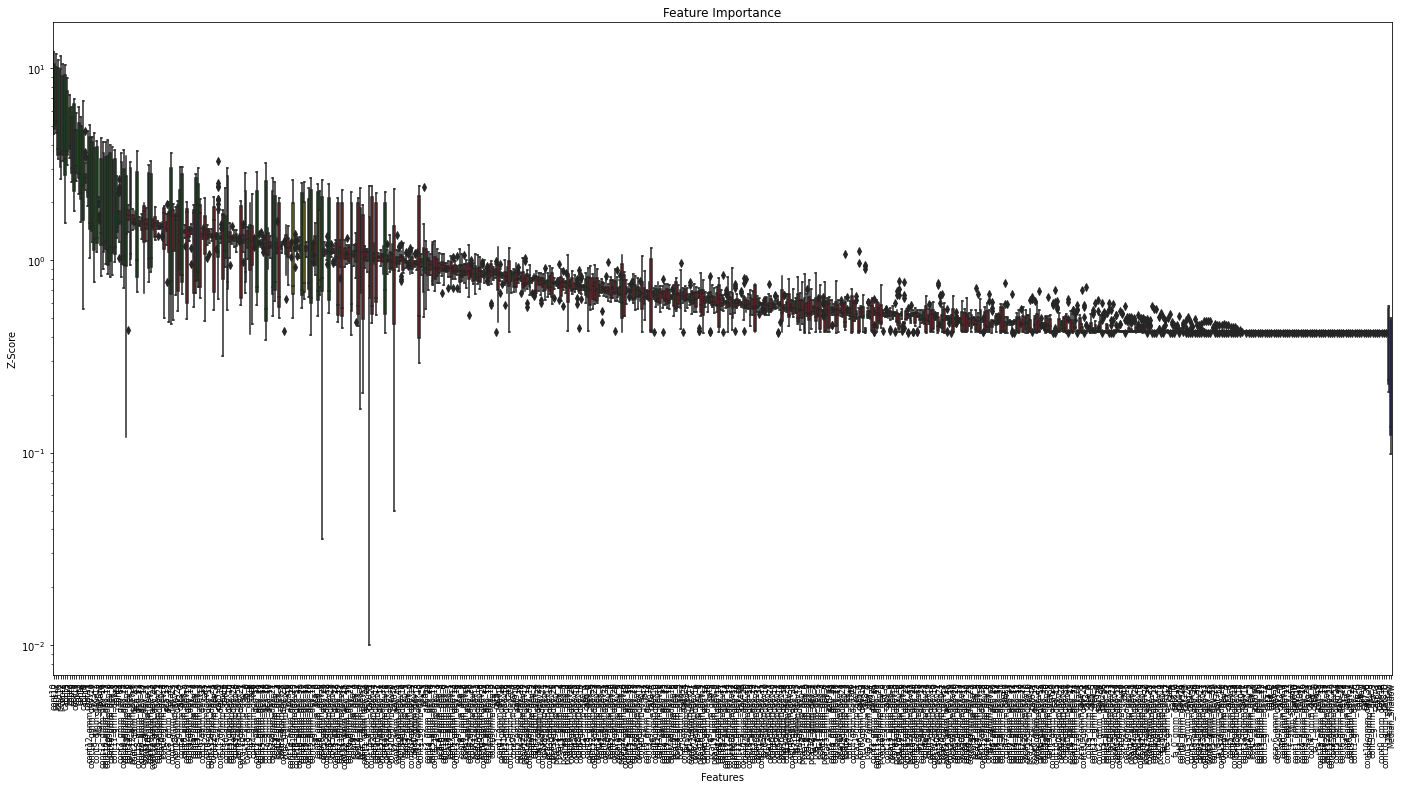

Selected features at fold 2 are: ['cat1_A', 'cat1_B', 'cat3_C', 'cat5_D', 'cat8_C', 'cont0', 'cont1', 'cont10', 'cont10_gmm_dev_1', 'cont10_gmm_dev_17', 'cont10_gmm_dev_20', 'cont10_gmm_dev_24', 'cont10_gmm_dev_3', 'cont10_gmm_dev_4', 'cont10_gmm_dev_8', 'cont11', 'cont11_gmm_dev_3', 'cont12', 'cont12_gmm_dev_12', 'cont12_gmm_dev_16', 'cont12_gmm_dev_3', 'cont12_gmm_dev_8', 'cont13', 'cont2', 'cont2_gmm_dev_21', 'cont2_gmm_dev_7', 'cont2_gmm_dev_9', 'cont3', 'cont3_gmm_dev_1', 'cont3_gmm_dev_2', 'cont4', 'cont4_gmm_dev_1', 'cont4_gmm_dev_17', 'cont5', 'cont5_gmm_dev_10', 'cont6', 'cont7', 'cont7_gmm_dev_0', 'cont7_gmm_dev_14', 'cont7_gmm_dev_18', 'cont7_gmm_dev_28', 'cont8', 'cont9', 'cont9_gmm_dev_1', 'cont9_gmm_dev_15', 'cont9_gmm_dev_20', 'cont9_gmm_dev_9', 'fa_0', 'pca_11', 'pca_12', 'pca_2', 'pca_3', 'pca_7', 'pca_8', 'pca_8_gmm_dev_3']
FOLD 3/3


  0%|          | 0/50 [00:00<?, ?it/s]

40 attributes confirmed important: ['cont0', 'cont9_gmm_dev_15', 'cont4_gmm_dev_17', 'cont2', 'cont10', 'cont5', 'cont2_gmm_dev_7', 'cont6', 'cont13', 'cont4', 'cont12_gmm_dev_16', 'cont10_gmm_dev_20', 'cat1_B', 'pca_2', 'pca_3', 'cont12_gmm_dev_8', 'cont10_gmm_dev_24', 'cont8', 'cat1_A', 'cont5_gmm_dev_10', 'cont10_gmm_dev_17', 'pca_7', 'cat5', 'pca_12', 'cont9', 'cont12', 'cont7', 'cont11', 'cont3', 'cont11_gmm_dev_3', 'cont10_gmm_dev_8', 'cont7_gmm_dev_14', 'cont10_gmm_dev_3', 'cont12_gmm_dev_3', 'cont12_gmm_dev_12', 'cont9_gmm_dev_9', 'cont10_gmm_dev_1', 'pca_8', 'cat8_C', 'cont10_gmm_dev_4']
540 attributes confirmed unimportant: ['cont1_gmm_dev_6', 'pca_2_gmm_dev_1', 'cont10_gmm_dev_27', 'cont4_gmm_dev_13', 'pca_11_gmm_dev_3', 'cont10_gmm_dev_23', 'cont12_gmm_dev_11', 'pca_9_gmm_dev_2', 'pca_0_gmm_dev_2', 'cont4_gmm_dev_21', 'cont11_gmm_dev_10', 'cont5_gmm_dev_25', 'fa_0_gmm_dev_0', 'cont4_gmm_dev_5', 'pca_6_gmm_dev_4', 'cat4_B', 'cont7_gmm_dev_9', 'cont3_gmm_dev_23', 'cont0_gmm_d

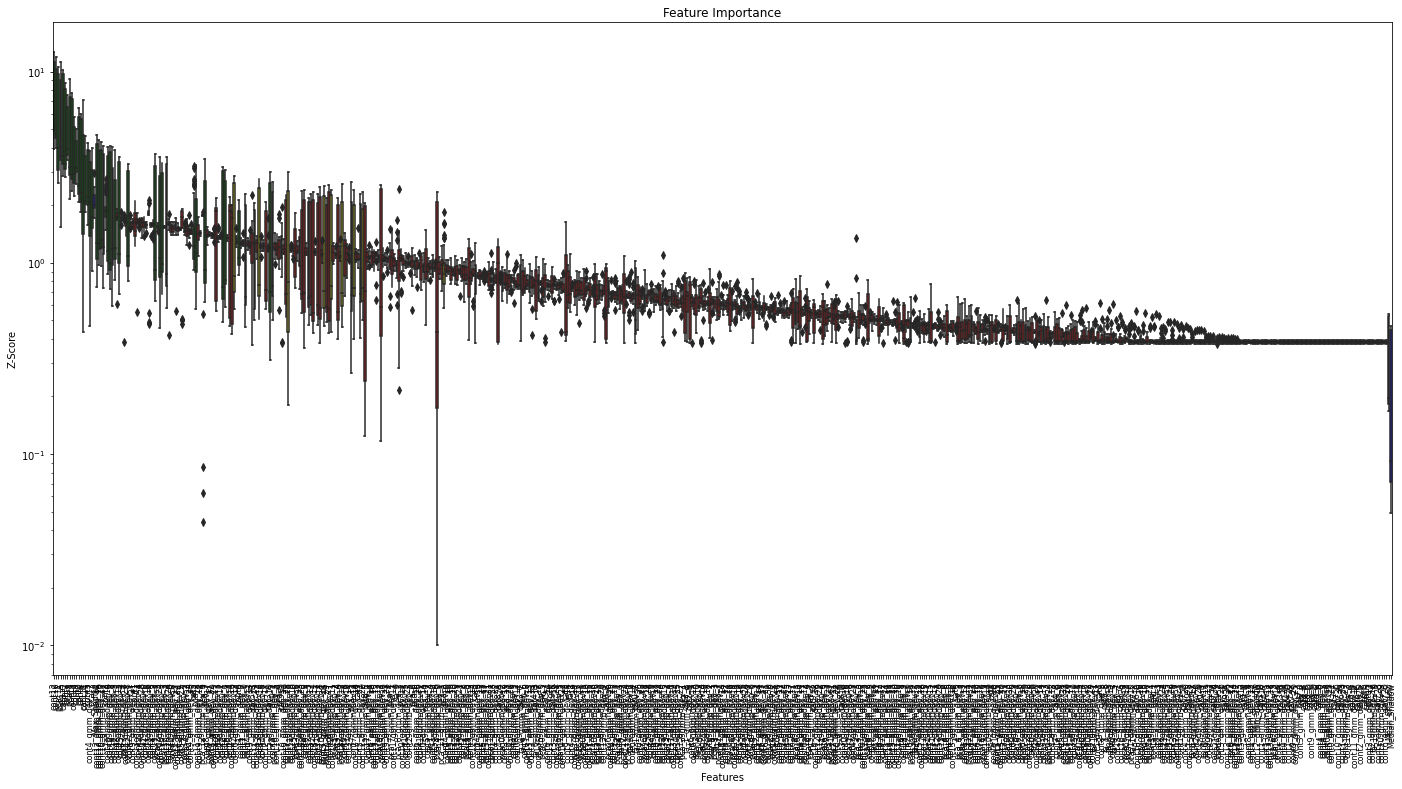

Selected features at fold 3 are: ['cat1_A', 'cat1_B', 'cat5', 'cat8_C', 'cont0', 'cont10', 'cont10_gmm_dev_1', 'cont10_gmm_dev_17', 'cont10_gmm_dev_20', 'cont10_gmm_dev_24', 'cont10_gmm_dev_3', 'cont10_gmm_dev_4', 'cont10_gmm_dev_8', 'cont11', 'cont11_gmm_dev_3', 'cont12', 'cont12_gmm_dev_12', 'cont12_gmm_dev_16', 'cont12_gmm_dev_3', 'cont12_gmm_dev_8', 'cont13', 'cont2', 'cont2_gmm_dev_7', 'cont3', 'cont4', 'cont4_gmm_dev_17', 'cont5', 'cont5_gmm_dev_10', 'cont6', 'cont7', 'cont7_gmm_dev_14', 'cont8', 'cont9', 'cont9_gmm_dev_15', 'cont9_gmm_dev_9', 'pca_12', 'pca_2', 'pca_3', 'pca_7', 'pca_8']


In [14]:
params = dict([('colsample_bytree', 0.1),
               ('learning_rate', 0.347),
               ('max_depth', 2),
               ('n_estimators', 1_000),
               ('reg_alpha', 1e-09),
               ('reg_lambda', 100.0),
               ('subsample', 1.0)])

folds = 3
skf = StratifiedKFold(n_splits=folds,
                      shuffle=True, 
                      random_state=0)

selected_columns = list()
    
for k, (train_idx, val_idx) in enumerate(skf.split(X_train, y_stratified)):
    
    print(f"FOLD {k+1}/{folds}")
    
    model = XGBRegressor(random_state=0, objective='reg:squarederror', **params)
    Feature_Selector = BorutaShap(model=model,
                                  importance_measure='shap', 
                                  classification=False)

    Feature_Selector.fit(X=X_train.iloc[train_idx, :], y=y_train[train_idx], n_trials=50, random_state=0)
    
    Feature_Selector.plot(which_features='all', figsize=(24,12))
    
    selected_columns.append(sorted(Feature_Selector.Subset().columns))
    
    print(f"Selected features at fold {k+1} are: {selected_columns[-1]}")

#### Here we finally have the good set of features to be used in this competition (at least using XGBoost - better to test for other algorithms)

In [15]:
final_selection = sorted({item for selection in selected_columns for item in selection})
print(final_selection)

['cat1_A', 'cat1_B', 'cat3_C', 'cat5', 'cat5_D', 'cat8_C', 'cat8_E', 'cont0', 'cont1', 'cont10', 'cont10_gmm_dev_1', 'cont10_gmm_dev_17', 'cont10_gmm_dev_20', 'cont10_gmm_dev_24', 'cont10_gmm_dev_3', 'cont10_gmm_dev_4', 'cont10_gmm_dev_8', 'cont11', 'cont11_gmm_dev_3', 'cont12', 'cont12_gmm_dev_12', 'cont12_gmm_dev_16', 'cont12_gmm_dev_20', 'cont12_gmm_dev_3', 'cont12_gmm_dev_8', 'cont13', 'cont2', 'cont2_gmm_dev_21', 'cont2_gmm_dev_7', 'cont2_gmm_dev_9', 'cont3', 'cont3_gmm_dev_1', 'cont3_gmm_dev_2', 'cont4', 'cont4_gmm_dev_1', 'cont4_gmm_dev_17', 'cont5', 'cont5_gmm_dev_10', 'cont6', 'cont7', 'cont7_gmm_dev_0', 'cont7_gmm_dev_14', 'cont7_gmm_dev_18', 'cont7_gmm_dev_28', 'cont8', 'cont9', 'cont9_gmm_dev_1', 'cont9_gmm_dev_15', 'cont9_gmm_dev_20', 'cont9_gmm_dev_9', 'fa_0', 'pca_11', 'pca_12', 'pca_2', 'pca_3', 'pca_7', 'pca_8', 'pca_8_gmm_dev_0', 'pca_8_gmm_dev_3']


## Happy Kaggling!